In [1]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import scipy.sparse 

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import PredefinedSplit
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
import xgboost as xgb
import lightgbm as lgbm

sys.path.insert(1, './')
import Utility
import imp
#imp.reload(Utility)  
from Utility import *

In [2]:
for p in [np, pd, sklearn, lgbm]:
    print (p.__name__, p.__version__)

numpy 1.18.1
pandas 1.0.1
sklearn 0.22.1
lightgbm 2.3.1


In this file, we load cleaned training data, train model, and save model.

# Load Cleaned Data

In [3]:
train_df = pd.read_hdf('../CleanData/trainDF.h5', 'df')
valid_df = pd.read_hdf('../CleanData/validDF.h5', 'df')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5068102 entries, 4488710 to 9556811
Data columns (total 49 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   shop_id                      int8   
 1   item_id                      int16  
 2   date_block_num               int8   
 3   avg_item_price               float32
 4   target                       float32
 5   target_shop                  float32
 6   target_item                  float32
 7   item_category_id             int8   
 8   target_item_category         float32
 9   avg_item_price_lag_1         float32
 10  target_lag_1                 float32
 11  target_shop_lag_1            float32
 12  target_item_lag_1            float32
 13  target_item_category_lag_1   float32
 14  avg_item_price_lag_2         float32
 15  target_lag_2                 float32
 16  target_shop_lag_2            float32
 17  target_item_lag_2            float32
 18  target_item_category_lag_2   float32

In [5]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1356992 entries, 9556812 to 10913803
Data columns (total 49 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   shop_id                      1356992 non-null  int8   
 1   item_id                      1356992 non-null  int16  
 2   date_block_num               1356992 non-null  int8   
 3   avg_item_price               1356992 non-null  float32
 4   target                       1356992 non-null  float32
 5   target_shop                  1356992 non-null  float32
 6   target_item                  1356992 non-null  float32
 7   item_category_id             1356992 non-null  int8   
 8   target_item_category         1356992 non-null  float32
 9   avg_item_price_lag_1         1356992 non-null  float32
 10  target_lag_1                 1356992 non-null  float32
 11  target_shop_lag_1            1356992 non-null  float32
 12  target_item_lag_1            135699

In [6]:
Y_train = train_df['target']
Y_valid = valid_df['target']

# LightGBM

In [7]:
lgbm_features = ['avg_item_price_lag_1', 'target_lag_1', 'target_shop_lag_1', 'target_item_lag_1', 
                 'target_item_category_lag_1', 'avg_item_price_lag_2', 'target_lag_2', 'target_shop_lag_2',
                 'target_item_lag_2', 'target_item_category_lag_2', 'avg_item_price_lag_3', 'target_lag_3', 
                 'target_shop_lag_3', 'target_item_lag_3', 'target_item_category_lag_3', 'avg_item_price_lag_4', 
                 'target_lag_4', 'target_shop_lag_4', 'target_item_lag_4', 'target_item_category_lag_4',
                 'avg_item_price_lag_5', 'target_lag_5', 'target_shop_lag_5', 'target_item_lag_5', 
                 'target_item_category_lag_5', 'avg_item_price_lag_6', 'target_lag_6', 'target_shop_lag_6',
                 'target_item_lag_6', 'target_item_category_lag_6', 'avg_item_price_lag_12', 'target_lag_12', 
                 'target_shop_lag_12', 'target_item_lag_12', 'target_item_category_lag_12', 'shop_mean',
                 'item_mean', 'shop_item_mean', 'item_category_mean', 'month']
lgbm_train_data = lgbm.Dataset(train_df[lgbm_features], label=Y_train, feature_name=lgbm_features) #categorical_feature
lgbm_valid_data = lgbm.Dataset(valid_df[lgbm_features], label=Y_valid, feature_name=lgbm_features)

params = {'objective':'regression', 'metric':['rmse'], 'boosting_type':'gbdt', 'num_rounds':100, 'eta':0.2, 
          'max_depth':8, 'min_data_in_leaf':150, 'min_gain_to_split':0.01, 
          'feature_fraction':0.7, 'bagging_freq':0, 'bagging_fraction':1.0, 'lambda_l1':0,
          'lambda_l2':0.001, 'early_stopping_round':20, 'verbosity':1}
eval_metrics = {}
start = time.time()
lgbm_model= lgbm.train(params, lgbm_train_data, valid_sets=[lgbm_train_data, lgbm_valid_data],
                       valid_names=['train', 'valid'], evals_result=eval_metrics, verbose_eval=True)
end = time.time()
print(end-start)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	train's rmse: 1.11494	valid's rmse: 1.00755
Training until validation scores don't improve for 20 rounds
[2]	train's rmse: 1.04573	valid's rmse: 0.951846
[3]	train's rmse: 0.99807	valid's rmse: 0.915016
[4]	train's rmse: 0.964546	valid's rmse: 0.888932
[5]	train's rmse: 0.922858	valid's rmse: 0.858541
[6]	train's rmse: 0.90596	valid's rmse: 0.846599
[7]	train's rmse: 0.879031	valid's rmse: 0.826928
[8]	train's rmse: 0.863188	valid's rmse: 0.813086
[9]	train's rmse: 0.851892	valid's rmse: 0.806566
[10]	train's rmse: 0.844632	valid's rmse: 0.801526
[11]	train's rmse: 0.837195	valid's rmse: 0.797549
[12]	train's rmse: 0.831354	valid's rmse: 0.795516
[13]	train's rmse: 0.82845	valid's rmse: 0.793538
[14]	train's rmse: 0.82494	valid's rmse: 0.792379
[15]	train's rmse: 0.822125	valid's rmse: 0.792038
[16]	train's rmse: 0.81999	valid's rmse: 0.790611
[17]	train's rmse: 0.812984	valid's rmse: 0.786412
[18]	train's rmse: 0.811198	valid's rmse: 0.785757
[19]	train's rmse: 0.808072	valid's rm

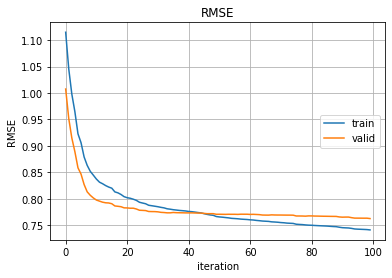

In [10]:
# Plot training progress of light GBM across number of iterations.
plot_lgbm_eval_metrics(eval_metrics)

In [11]:
# Show variable importance.
show_lgbm_var_imp(lgbm_model)

,feature,split,split_frac,gain,gain_frac
1,target_lag_1,149,4.966667,4.799038e+06,37.018824
3,target_item_lag_1,311,10.366667,1.917383e+06,14.790313
37,shop_item_mean,148,4.933333,1.541907e+06,11.893961
35,shop_mean,235,7.833333,9.853041e+05,7.600439
36,item_mean,208,6.933333,8.219406e+05,6.340286
6,target_lag_2,55,1.833333,4.593819e+05,3.543580
7,target_shop_lag_2,86,2.866667,3.246442e+05,2.504241
38,item_category_mean,206,6.866667,2.800450e+05,2.160211
39,month,171,5.700000,2.307426e+05,1.779902
9,target_item_category_lag_2,126,4.200000,1.929581e+05,1.488440


In [12]:
# Predict on training and validation set.
Z_train_lgbm = lgbm_model.predict(train_df[lgbm_features])
Z_valid_lgbm = lgbm_model.predict(valid_df[lgbm_features]).clip(0,20)

In [13]:
# Compute performance on training and validation set.
compute_reg_score(Y_train, Z_train_lgbm)
print('-'*100)
compute_reg_score(Y_valid, Z_valid_lgbm)

Count Y: 5068102
Sum Y: 1488707.0
Avg Y: 0.29374054074287415
Avg Z: 0.2937405355158621
r: 0.792027359733317
fr: 1.039283492454184
R2: 0.626411074653827
RMSE: 0.7410751181344507
MAE: 0.28809301305536694
----------------------------------------------------------------------------------------------------
Count Y: 1356992
Sum Y: 359979.0
Avg Y: 0.2652771770954132
Avg Z: 0.2548725722475108
r: 0.7104745468128915
fr: 0.9911100796058334
R2: 0.5046411858309808
RMSE: 0.7623360977813964
MAE: 0.28481842688531606


# Linear Model

In [14]:
# Start with linear model using all features.  We will use elastic net with some parameters, and fine tune later.
lr_features = ['avg_item_price_lag_1', 'target_lag_1', 'target_shop_lag_1', 'target_item_lag_1', 
                 'target_item_category_lag_1', 'avg_item_price_lag_2', 'target_lag_2', 'target_shop_lag_2',
                 'target_item_lag_2', 'target_item_category_lag_2', 'avg_item_price_lag_3', 'target_lag_3', 
                 'target_shop_lag_3', 'target_item_lag_3', 'target_item_category_lag_3', 'avg_item_price_lag_4', 
                 'target_lag_4', 'target_shop_lag_4', 'target_item_lag_4', 'target_item_category_lag_4',
                 'avg_item_price_lag_5', 'target_lag_5', 'target_shop_lag_5', 'target_item_lag_5', 
                 'target_item_category_lag_5', 'avg_item_price_lag_6', 'target_lag_6', 'target_shop_lag_6',
                 'target_item_lag_6', 'target_item_category_lag_6', 'avg_item_price_lag_12', 'target_lag_12', 
                 'target_shop_lag_12', 'target_item_lag_12', 'target_item_category_lag_12', 'shop_mean',
                 'item_mean', 'shop_item_mean', 'item_category_mean', 'month']
#lr_model = LinearRegression(normalize=True, n_jobs=-1)
lr_model = ElasticNet(normalize=True, alpha=1e-8, l1_ratio=0.1)
lr_model.fit(train_df[lr_features], Y_train)

ElasticNet(alpha=1e-08, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [15]:
# Predict on training and validation set.
Z_train_lr = lr_model.predict(train_df[lr_features])
Z_valid_lr = lr_model.predict(valid_df[lr_features]).clip(0,20)

In [16]:
# Compute performance on training and validation set.
compute_reg_score(Y_train, Z_train_lr)
print('-'*100)
compute_reg_score(Y_valid, Z_valid_lr)

Count Y: 5068102
Sum Y: 1488707.0
Avg Y: 0.29374054074287415
Avg Z: 0.2937405363980431
r: 0.6416182672395958
fr: 1.0225127162726126
R2: 0.41147443120378624
RMSE: 0.9301391041520919
MAE: 0.3503528175829209
----------------------------------------------------------------------------------------------------
Count Y: 1356992
Sum Y: 359979.0
Avg Y: 0.2652771770954132
Avg Z: 0.31740612925307055
r: 0.6031473507315439
fr: 0.9720847150975326
R2: 0.3611704642461234
RMSE: 0.8657231497112244
MAE: 0.34794879982227955


In [17]:
# Let's examine the coeeficients estimated by elastic net.
beta = lr_model.coef_
beta = pd.Series(beta, index=lr_features)
beta

avg_item_price_lag_1          -4.682508e-05
target_lag_1                   3.327415e-01
target_shop_lag_1              1.522261e-06
target_item_lag_1              1.312973e-03
target_item_category_lag_1    -1.278379e-07
avg_item_price_lag_2          -1.669665e-05
target_lag_2                   9.092014e-02
target_shop_lag_2             -2.206795e-05
target_item_lag_2             -5.733206e-04
target_item_category_lag_2    -4.822814e-06
avg_item_price_lag_3           5.983566e-07
target_lag_3                   4.778345e-02
target_shop_lag_3             -1.683601e-05
target_item_lag_3             -5.034187e-05
target_item_category_lag_3    -1.587882e-06
avg_item_price_lag_4          -1.518298e-05
target_lag_4                   1.966541e-02
target_shop_lag_4             -1.796683e-05
target_item_lag_4             -1.287701e-04
target_item_category_lag_4    -6.351687e-08
avg_item_price_lag_5          -1.433026e-05
target_lag_5                   2.874279e-02
target_shop_lag_5             -8

In [18]:
# Beta coefficients are all non-zeros.  We will need to tune elastic net to do feature selection for linear model.

In [19]:
# Do cross-validation to tune elastic net.
# Prepare cross validation data.
test_fold = np.full(train_df.shape[0], -1, dtype=np.int8)
sel = train_df['date_block_num']>=25 #use 25,26,27 as validation set when tuning elastic net
test_fold[sel] = 0    
ps = PredefinedSplit(test_fold=test_fold)
# Base params
max_iter = 1000
alphas = None
#alphas = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
n_alphas = 10
#l1_ratio = [.1, .3, .5, .7, .9, .95, .99, 1]
l1_ratio = [.1, .5, 1]
ecv_params = {'cv': ps, 'random_state': 0, # Changing this could do ensembling options    
              'alphas': alphas, 'n_alphas': n_alphas, 'l1_ratio': l1_ratio,
              'eps': 0.001, 'tol': 0.0001, 'max_iter': max_iter, 'fit_intercept': True, 'normalize': True, 
              'positive': False, 'selection': 'random', 'verbose': 2, 'n_jobs': -1
             }
# Tune
ecv = ElasticNetCV()
ecv = ecv.set_params(**ecv_params)
ecv = ecv.fit(train_df[lr_features], Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Path: 000 out of 010
Path: 001 out of 010
Path: 000 out of 010
Path: 002 out of 010
Path: 001 out of 010
Path: 003 out of 010
Path: 002 out of 010
Path: 004 out of 010
Path: 003 out of 010
Path: 004 out of 010
Path: 005 out of 010
Path: 006 out of 010
Path: 005 out of 010
Path: 007 out of 010
Path: 006 out of 010
Path: 008 out of 010
Path: 007 out of 010
Path: 009 out of 010
Path: 008 out of 010
Path: 009 out of 010
Path: 000 out of 010
Path: 001 out of 010
Path: 002 out of 010
Path: 003 out of 010
Path: 004 out of 010
Path: 005 out of 010
Path: 006 out of 010
Path: 007 out of 010
Path: 008 out of 010
Path: 009 out of 010


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.5s finished


In [20]:
# Get best parameter from ElasticNetCV.
best_params = (ecv.alpha_, ecv.l1_ratio_, ecv.n_iter_)
best_params

(3.1661332781454837e-06, 1.0, 55)

In [21]:
# Get the corresponding elastic net coefficients.
beta = pd.Series(ecv.coef_, index=lr_features)
beta

avg_item_price_lag_1          -5.032998e-05
target_lag_1                   3.656257e-01
target_shop_lag_1             -0.000000e+00
target_item_lag_1              9.176079e-04
target_item_category_lag_1    -0.000000e+00
avg_item_price_lag_2          -4.954245e-06
target_lag_2                   8.128958e-02
target_shop_lag_2             -2.001247e-05
target_item_lag_2             -4.758754e-04
target_item_category_lag_2    -4.365288e-06
avg_item_price_lag_3          -0.000000e+00
target_lag_3                   4.220605e-02
target_shop_lag_3             -1.634069e-05
target_item_lag_3             -0.000000e+00
target_item_category_lag_3    -2.767410e-07
avg_item_price_lag_4          -6.809534e-06
target_lag_4                   1.024049e-02
target_shop_lag_4             -1.655187e-05
target_item_lag_4             -1.779435e-05
target_item_category_lag_4    -0.000000e+00
avg_item_price_lag_5          -7.329395e-06
target_lag_5                   2.239806e-02
target_shop_lag_5             -5

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

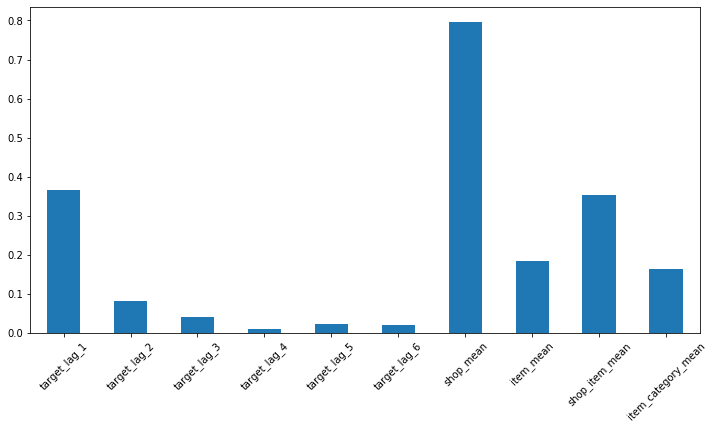

In [22]:
# Let's visualize the magnitude of coefficients estimated by the best elastic net model.
fig = plt.figure(figsize=(12,6))
sel = np.abs(beta)>0.01
beta[sel].plot.bar()
plt.xticks(rotation=45)

In [23]:
# Generate predictions from the best elastic net model.
Z_train_ecv = ecv.predict(train_df[lr_features])
Z_valid_ecv = ecv.predict(valid_df[lr_features]).clip(0,20)

In [24]:
# Compute performance of the best elastic net model.
compute_reg_score(Y_train, Z_train_ecv)
print('-'*100)
compute_reg_score(Y_valid, Z_valid_ecv)

Count Y: 5068102
Sum Y: 1488707.0
Avg Y: 0.29374054074287415
Avg Z: 0.2937405363980436
r: 0.640858115257683
fr: 1.0182084458087866
R2: 0.41056777373735354
RMSE: 0.9308552948016093
MAE: 0.3470643763449833
----------------------------------------------------------------------------------------------------
Count Y: 1356992
Sum Y: 359979.0
Avg Y: 0.2652771770954132
Avg Z: 0.3176384568119213
r: 0.6037251728589164
fr: 0.9709495312789024
R2: 0.3618208500895894
RMSE: 0.8652823455277013
MAE: 0.3486087998770418


In [25]:
# Performance is comparable to the model without fine-tuning.

In [26]:
# We will retrain linear model on the training data using features selected by the best elastic net model only.
lr_features = ['target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_4', 'target_lag_5', 'target_lag_6', 
               'shop_mean', 'item_mean', 'shop_item_mean', 'item_category_mean']
lr_model = LinearRegression(normalize=True, n_jobs=-1)
lr_model.fit(train_df[lr_features], Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

In [27]:
# Let's examine the estimated coefficients.
beta = lr_model.coef_
beta = pd.Series(beta, index=lr_features)
beta

target_lag_1          0.390254
target_lag_2          0.065788
target_lag_3          0.035519
target_lag_4          0.003315
target_lag_5          0.015460
target_lag_6          0.011241
shop_mean             0.402589
item_mean             0.203257
shop_item_mean        0.404079
item_category_mean    0.172647
dtype: float64

In [28]:
# Predict on training and validation set.
Z_train_lr = lr_model.predict(train_df[lr_features])
Z_valid_lr = lr_model.predict(valid_df[lr_features]).clip(0,20)

In [29]:
# Compute performance on training and validation set.
compute_reg_score(Y_train, Z_train_lr)
print('-'*100)
compute_reg_score(Y_valid, Z_valid_lr)

Count Y: 5068102
Sum Y: 1488707.0
Avg Y: 0.29374054074287415
Avg Z: 0.2937405363980436
r: 0.6304554729603922
fr: 0.9999999915421738
R2: 0.39747409286985846
RMSE: 0.9411375419697358
MAE: 0.3391042227989815
----------------------------------------------------------------------------------------------------
Count Y: 1356992
Sum Y: 359979.0
Avg Y: 0.2652771770954132
Avg Z: 0.283242317688553
r: 0.597095783902275
fr: 0.961311261703089
R2: 0.3556707931790931
RMSE: 0.8694416606068114
MAE: 0.322825979722477


# Ensembling

We will combine predictions from light GBM and linear model. First, check that the two set of predictions are not overly correlated.

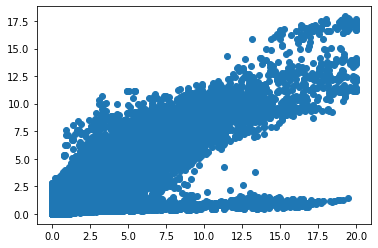

In [30]:
plt.scatter(Z_valid_lgbm, Z_valid_lr)

In [31]:
# They are somewhat correlated.

### Weighted Averaging

We will use a simple convex combination to combine the two set of predictions.  We will find the optimal combination coefficient alpha using grid search on the range of alphas_to_try.  The best alpha should have the lowest RMSE on the validation predictions.

In [32]:
alphas_to_try = np.linspace(0, 1, 1001)

best_alpha = 0 
rmse_train_simple_mix = np.inf 
for alpha in alphas_to_try:
    Z_mix = alpha*Z_valid_lgbm + (1 - alpha)*Z_valid_lr
    rmse = np.sqrt(mean_squared_error(Y_valid, Z_mix)) 
    if rmse<rmse_train_simple_mix:
        best_alpha = alpha
        rmse_train_simple_mix = rmse

In [33]:
best_alpha

0.974

In [34]:
# Compute performance of the best combined validation prediction.
Z_mix = best_alpha*Z_valid_lgbm + (1 - best_alpha)*Z_valid_lr
compute_reg_score(Y_valid, Z_mix)

Count Y: 1356992
Sum Y: 359979.0
Avg Y: 0.2652771770954132
Avg Z: 0.255610185628978
r: 0.7105128447943058
fr: 0.9982715998932865
R2: 0.5047473242242364
RMSE: 0.7622544221748303
MAE: 0.285438631177365
